In [18]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy import misc

from copy import deepcopy

In [4]:
map1 = misc.imread('/Users/pfoley/map_projections/input_images/bigWorld.jpg')

/usr/local/lib/python2.7/site-packages/PIL/Image.py:2215: DecompressionBombWarning: Image size (117136818 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


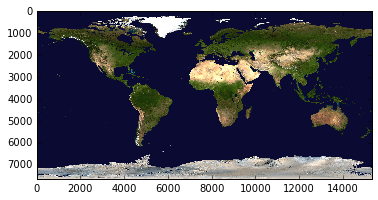

In [5]:
plt.imshow(map1)

This is not a Gall-Peters projection.  It is a [Plate-Carre projection](https://en.wikipedia.org/wiki/Equirectangular_projection).  

It follows 
\begin{eqnarray}
u &=& \lambda \cos{\phi_1} \\
v &=& \phi
\end{eqnarray}

The Plate-Carre projection is the special case where $\phi_1 = 0.0$.

In [6]:
(ny, nx, _) = map1.shape
xs, ys = np.meshgrid(np.arange(0, nx), np.arange(0, ny))
xs = xs.flatten().astype(float)
ys = ys.flatten().astype(float)

print '`xs` has shape {} and range {}'.format(xs.shape,
                                             (np.amin(xs), np.amax(xs)))

print '`ys` has shape {} and range {}'.format(ys.shape,
                                             (np.amin(ys), np.amax(ys)))


mapdims = (nx, ny)
print 'mapdims are {}'.format(mapdims)

#  Pixel values are from 0 to N, so we need to do
#  some trickery to map them to (-pi,pi) and (-pi/2, pi/2)
def longitudeAndLatitudeFromPCPixel(x, y, mapdims):
    nx, ny = mapdims
    longitude = 2*np.pi * ((x / float(nx)) - 0.5)
    latitude = np.pi * ((y / float(ny)) - 0.5)
    return(longitude, latitude)

`xs` has shape (117136818,) and range (0.0, 15305.0)
`ys` has shape (117136818,) and range (0.0, 7652.0)
mapdims are (15306, 7653)


Now we can use the same other functions, but we need a new function for pixels from longitude and latitude

In [16]:
def pixel_for_plate_carre(longitude, latitude, mapdims):
    nx, ny = mapdims
    
    u = nx * (0.5 + (longitude / (2*np.pi)))
    v = ny * (0.5 + (latitude / np.pi))
    
    u = u.astype(int)
    v = v.astype(int)
    
    u[u == nx] = nx - 1
    v[v == ny] = ny - 1
    
    return(u,v)

Now let's define a `transform_platecarre_map` function, doing the whole thing.

In [20]:
def transform_platecarre_map(map_image, rot_mat, debug = True):
    ny, nx, _ = map_image.shape
    mapdims = (nx, ny)
    
    if debug:
        print 'ny, nx are {} and {}'.format(ny, nx)
    xs, ys = np.meshgrid(np.arange(0, nx), np.arange(0, ny))
    xs = xs.flatten().astype(float)
    ys = ys.flatten().astype(float)
    if debug:
        print 'shape of xs and ys are {} and {}'.format(xs.shape, ys.shape)
        print 'xs min and max are {} and {}'.format(min(xs), max(xs))
        print 'ys min and max are {} and {}'.format(min(ys), max(ys))


    longs, lats = longitudeAndLatitudeFromPCPixel(xs, ys, mapdims)
    if debug:
        print 'shape of longs and lats are {} and {}'.format(longs.shape, lats.shape)
        print'longitudes histogram'
        plt.hist(longs)
        print 'latitudes histogram'
        plt.hist(lats)

    xxs, yys, zzs = spatialCoordinatesFromLongitudeAndLatitude(longs, lats)
    if debug:
        print 'pre rotation hists'
        plt.hist(xxs)
        plt.hist(yys)
        plt.hist(zzs)
    new_xxyyzz = np.dot(rot_mat, np.array([xxs, yys, zzs]))
    
    new_xxs = np.squeeze(np.array(new_xxyyzz[0, :]))
    new_yys = np.squeeze(np.array(new_xxyyzz[1, :]))
    new_zzs = np.squeeze(np.array(new_xxyyzz[2, :]))
    if debug:
        print 'post rotation hists'
        plt.hist(new_xxs)
        plt.hist(new_yys)
        plt.hist(new_zzs)

    new_longs, new_lats = longitudeAndLatitudeFromSpatialCoordinates(new_xxs, new_yys, new_zzs)
    if debug:
        print 'new longs'
        plt.hist(new_longs)
        print 'new lats'
        plt.hist(new_lats)
    new_xs, new_ys = pixel_for_plate_carre(new_longs, new_lats, mapdims)
    if debug:
        print 'new x pixels and new y pixels'
        plt.hist(new_xs)
        plt.hist(new_ys)

        print 'shape of new xs and new ys is '
        new_xs.shape
        new_ys.shape
    
        print 'ny, nx are {}, and {}'.format(ny, nx)
    
    
    new_xs.shape = (ny, nx)
    new_ys.shape = (ny, nx)
    
    new_map = deepcopy(map_image)
    new_map[:, :, 0] = map_image[new_ys, new_xs, 0]
    new_map[:, :, 1] = map_image[new_ys, new_xs, 1]
    new_map[:, :, 2] = map_image[new_ys, new_xs, 2]
    
    plt.imshow(new_map)
    return(new_map)


In [10]:
from projections import rotationFromXYZ
rot = rotationFromXYZ(np.pi/5, -np.pi/3, 1.3*np.pi)

In [19]:
def spatialCoordinatesFromLongitudeAndLatitude(longitude, latitude):
    #longitude, latitude = longLat
    x = np.cos(longitude) * np.cos(latitude)
    y = np.sin(longitude) * np.cos(latitude)
    z = np.sin(latitude)
    return(x, y, z)

def longitudeAndLatitudeFromSpatialCoordinates(xxs, yys, zzs):
    latitude = np.arcsin(zzs)
    longitude = np.arctan2(yys, xxs)

    #  Now we need to put longitude onto the (-pi, pi) scale
    #  rather than the (0, 2*pi) scale.
    need_to_be_flipped = np.greater(longitude, np.pi)
    longitude = longitude - need_to_be_flipped * (longitude) - need_to_be_flipped * (2*np.pi - longitude)

    return((longitude, latitude))

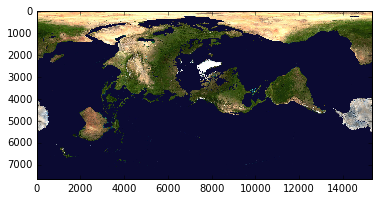

In [21]:
big2 = transform_platecarre_map(map1, rot, debug = False)

In [23]:
misc.imsave("/Users/pfoley/Desktop/big_transformed_platecarre_map.jpg", big2)

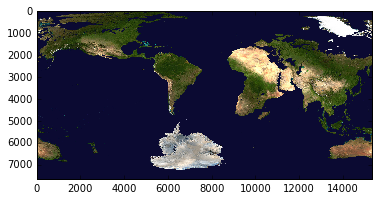

In [31]:
big3 = transform_platecarre_map(map1, 
                                rotationFromXYZ(*np.random.uniform(low = 0.0, high = 2 * np.pi, size = 3)),
                                debug = False)

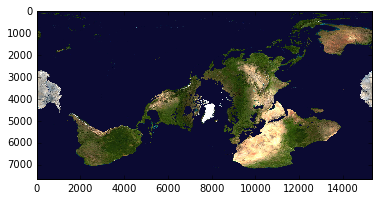

In [32]:
big4 = transform_platecarre_map(map1, 
                                rotationFromXYZ(*np.random.uniform(low = 0.0, high = 2 * np.pi, size = 3)),
                                debug = False)

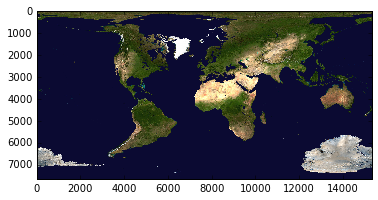

In [33]:
big5 = transform_platecarre_map(map1, 
                                rotationFromXYZ(*np.random.uniform(low = 0.0, high = 2 * np.pi, size = 3)),
                                debug = False)

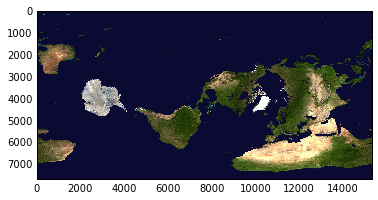

In [34]:
big6 = transform_platecarre_map(map1, 
                                rotationFromXYZ(*np.random.uniform(low = 0.0, high = 2 * np.pi, size = 3)),
                                debug = False)

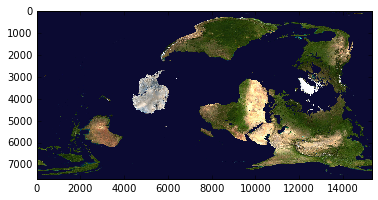

In [35]:
big7 = transform_platecarre_map(map1, 
                                rotationFromXYZ(*np.random.uniform(low = 0.0, high = 2 * np.pi, size = 3)),
                                debug = False)

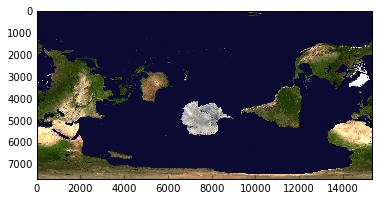

In [36]:
big8 = transform_platecarre_map(map1, 
                                rotationFromXYZ(*np.random.uniform(low = 0.0, high = 2 * np.pi, size = 3)),
                                debug = False)

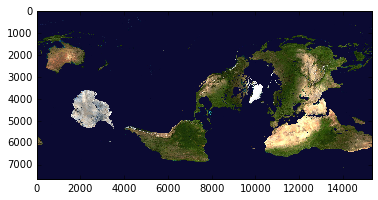

In [37]:
big9 = transform_platecarre_map(map1, 
                                rotationFromXYZ(*np.random.uniform(low = 0.0, high = 2 * np.pi, size = 3)),
                                debug = False)

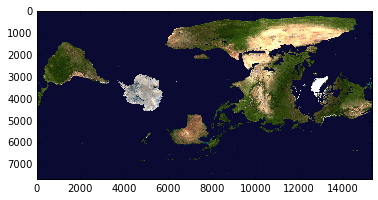

In [38]:
big10 = transform_platecarre_map(map1, 
                                rotationFromXYZ(*np.random.uniform(low = 0.0, high = 2 * np.pi, size = 3)),
                                debug = False)

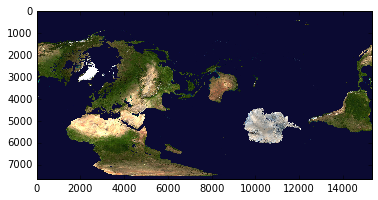

In [39]:
big11 = transform_platecarre_map(map1, 
                                rotationFromXYZ(*np.random.uniform(low = 0.0, high = 2 * np.pi, size = 3)),
                                debug = False)

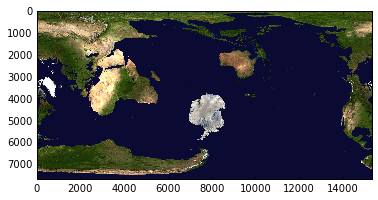

In [40]:
big12 = transform_platecarre_map(map1, 
                                rotationFromXYZ(*np.random.uniform(low = 0.0, high = 2 * np.pi, size = 3)),
                                debug = False)

In [41]:
misc.imsave("/Users/pfoley/Desktop/rand2.jpg", big2)
misc.imsave("/Users/pfoley/Desktop/rand3.jpg", big3)
misc.imsave("/Users/pfoley/Desktop/rand4.jpg", big4)
misc.imsave("/Users/pfoley/Desktop/rand5.jpg", big5)
misc.imsave("/Users/pfoley/Desktop/rand6.jpg", big6)
misc.imsave("/Users/pfoley/Desktop/rand7.jpg", big7)
misc.imsave("/Users/pfoley/Desktop/rand8.jpg", big8)
misc.imsave("/Users/pfoley/Desktop/rand9.jpg", big9)
misc.imsave("/Users/pfoley/Desktop/rand10.jpg", big10)
misc.imsave("/Users/pfoley/Desktop/rand11.jpg", big11)
misc.imsave("/Users/pfoley/Desktop/rand12.jpg", big12)